In [1]:
%matplotlib inline

import pandas as pd
import geopandas
import json
from shapely.geometry import Point
import folium
import difflib
from geopy.distance import vincenty

# Analyse comparative des quantités de points d'arrêts

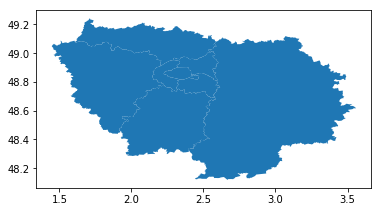

In [2]:
#contenus géographiques qu'on utilisera
zones = geopandas.read_file('ref_data/idf_departements.geojson', driver='GeoJSON')
zones = zones[['name', 'geometry']]
zones.plot()

In [3]:
#on charge les données
osm_stoppoints = pd.read_csv("../data/osm-transit-extractor_stop_points.csv", dtype=str)
gtfs_stoppoints = pd.read_csv("../data/gtfs_stops.txt", dtype=str)
gtfs_stoppoints = gtfs_stoppoints[gtfs_stoppoints['location_type'] == '0'] #on retire les zones d'arrêts

#on ajoute la dimension géographique
crs = {'init': 'epsg:4326'}
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['stop_lon']),float(row['stop_lat']))

gtfs_stoppoints['geometry'] = gtfs_stoppoints.apply(gtfs_lat_lon_to_geom, axis=1)
gtfs_stoppoints.drop('stop_lon', axis=1, inplace=True)
gtfs_stoppoints.drop('stop_lat', axis=1, inplace=True)

def osm_lat_lon_to_geom(row):
    return Point(float(row['lon']),float(row['lat']))

osm_stoppoints['geometry'] = osm_stoppoints.apply(osm_lat_lon_to_geom, axis=1)
osm_stoppoints.drop('lon', axis=1, inplace=True)
osm_stoppoints.drop('lat', axis=1, inplace=True)

osm_stops_geo = geopandas.GeoDataFrame(osm_stoppoints, crs=crs, geometry=osm_stoppoints.geometry)
gtfs_stops_geo = geopandas.GeoDataFrame(gtfs_stoppoints, crs=crs, geometry=gtfs_stoppoints.geometry)

#on calcule le nombre par département
gtfs_stoppoints_with_zones = geopandas.sjoin(gtfs_stops_geo, zones.copy(), op='within')
counts_gtfs_stops = gtfs_stoppoints_with_zones.groupby('name').size()
zones_with_gtfs_stops_count = zones[['name', 'geometry']].merge(counts_gtfs_stops.reset_index(name='nb_stoppoints_officiel'))

osm_stoppoints_with_zones = geopandas.sjoin(osm_stops_geo, zones.copy(), op='within')
counts_osm_stops = osm_stoppoints_with_zones.groupby('name_right').size()
zones_with_stoppoints_count = zones_with_gtfs_stops_count.merge(counts_osm_stops.reset_index(name='nb_stoppoints_osm'), left_on="name", right_on='name_right')
zones_with_stoppoints_count.drop('name_right', axis=1, inplace=True)

#on calcule le pourcentage de couverture d'OSM par rapport à l'officiel
zones_with_stoppoints_count["couverture_stoppoints_osm"] = zones_with_stoppoints_count["nb_stoppoints_osm"] * 100.0 / zones_with_stoppoints_count["nb_stoppoints_officiel"]

zones_with_stoppoints_count

,name,geometry,nb_stoppoints_officiel,nb_stoppoints_osm,couverture_stoppoints_osm
0,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",8259,4521,54.740283
1,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",4035,2565,63.568773
2,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",5929,3610,60.887165
3,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",4746,2967,62.515803
4,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",3747,2765,73.792367
5,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",8314,3943,47.426028
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",3158,2687,85.085497
7,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",3059,2381,77.835894


In [4]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_stoppoints_count, data=zones_with_stoppoints_count, columns=['name', 'couverture_stoppoints_osm'],
             key_on='feature.properties.name', fill_color='YlOrRd', highlight=True)


m

Pourcentage de couverture global sur l'Île-de-France en points d'arrêts:

In [5]:
len(osm_stoppoints) * 100.0 / len(gtfs_stoppoints)

61.172935945198894

NB : les données OSM sont déjà filtrées sur les bus, mais pas les données officielles

# Analyse comparative en utilisant les lignes desservies

In [6]:
# on charge les lignes dans les deux sources
gtfs_lines = pd.read_csv("../data/gtfs_routes.txt", dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

osm_lines = pd.read_csv("../data/osm-transit-extractor_lines.csv", dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']

Pourcentage de couverture en lignes de bus:

In [7]:
len(osm_lines) * 100.0 / len(gtfs_lines)

48.41578654808227

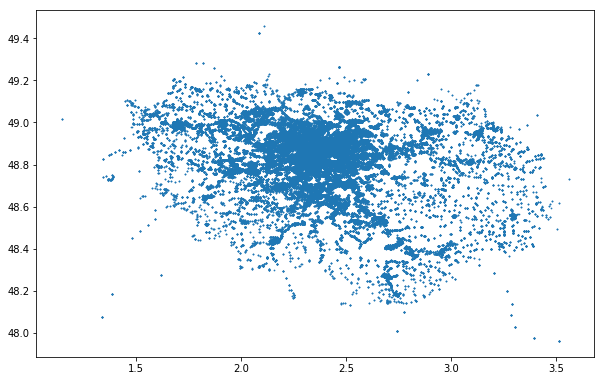

In [8]:
#préparation géographique des données officielles pour les routepoints
gtfs_routepoints = pd.read_csv("../data/gtfs_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
crs = {'init': 'epsg:4326'}   
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

gtfs_routepoints['geometry'] = gtfs_routepoints.apply(gtfs_lat_lon_to_geom, axis=1)

gtfs_geo = geopandas.GeoDataFrame(gtfs_routepoints, crs=crs, geometry=gtfs_routepoints.geometry)
gtfs_geo.plot(markersize=0.5, figsize=(10, 10))

#TODO : modifier le script de retraitement pour ne garder que les bus

gtfs_routepoints_with_zones = geopandas.sjoin(gtfs_geo, zones.copy(), op='within')
counts_gtfs = gtfs_routepoints_with_zones.groupby('name').size()
zones_with_gtfs_count = zones.merge(counts_gtfs.reset_index(name='nb_stops_officiel'))

In [9]:
#préparation géographique des données OSM pour les routepoints
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)
def osm_lat_lon_to_geom(row):
    return Point(float(row['osm_lon']),float(row['osm_lat']))

osm_routepoints['geometry'] = osm_routepoints.apply(osm_lat_lon_to_geom, axis=1)
osm_routepoints.drop('osm_lon', axis=1, inplace=True)
osm_routepoints.drop('osm_lat', axis=1, inplace=True)

osm_geo = geopandas.GeoDataFrame(osm_routepoints, crs=crs, geometry=osm_routepoints.geometry)
#osm_geo.plot(markersize=0.5, figsize=(10, 10))

osm_routepoints_with_zones = geopandas.sjoin(osm_geo, zones.copy(), op='within')
counts_osm = osm_routepoints_with_zones.groupby('name').size()
zones_with_routepoints_count = zones_with_gtfs_count.merge(counts_osm.reset_index(name='nb_stops_osm'))
zones_with_routepoints_count["couverture_osm"] = zones_with_routepoints_count["nb_stops_osm"] * 100.0 / zones_with_routepoints_count["nb_stops_officiel"]

zones_with_routepoints_count

,name,geometry,nb_stops_officiel,nb_stops_osm,couverture_osm
0,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",26420,2894,10.953823
1,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",8923,2185,24.487280
2,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",14640,3553,24.269126
3,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",10632,3085,29.016178
4,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",8042,3444,42.825168
5,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",22396,1705,7.612967
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",7801,3440,44.096911
7,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",7997,4434,55.445792


In [10]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_routepoints_count, data=zones_with_routepoints_count, columns=['name', 'couverture_osm'],
             key_on='feature.properties.name', fill_color='YlGn', highlight=True)


m

Pourcentage global de couverture OSM sur l'Île-de-France en routepoints : 

In [11]:
len(osm_routepoints) * 100.0 / len(gtfs_routepoints)

22.992521020114275

# Analyse quantitative par réseau

TODO : faire une table de correspondance entre les réseaux des deux sources car on en écarte plus de la moitié parce que ça ne matche pas exactement

Et trouver un moyen sympa de le visualiser

In [12]:
osm_networks = pd.DataFrame(osm_routepoints.groupby('osm_network').size()).reset_index()
gtfs_networks = pd.DataFrame(gtfs_routepoints.groupby('gtfs_agency_name').size()).reset_index()
networks = gtfs_networks.merge(osm_networks, how='inner', right_on=['osm_network'], left_on=['gtfs_agency_name'])
networks.rename(columns={'0_x': 'gtfs_count', '0_y': 'osm_count'}, inplace=True)
networks.drop('osm_network', axis=1, inplace=True)
networks['osm_couverture'] = networks['osm_count'] * 100.0 / networks['gtfs_count']
#networks

# Analyse qualitative

uniquement sur les données où les référentiels d'Île-de-France ont été intégrés

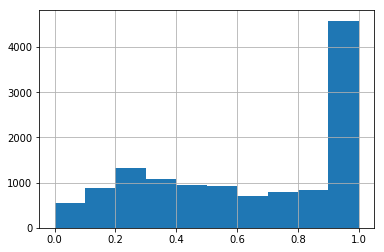

In [13]:
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)

#TODO : découper et dupliquer les routepoints où plusieurs codes STIF sont associés

    
gtfs_routepoints.fillna("", inplace=True)
gtfs_routepoints = gtfs_routepoints[gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']

#on fusionne sur les codes d'arrêts et les codes de lignes
routepoints = gtfs_routepoints.merge(
                    osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
routepoints.fillna("", inplace=True)

def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

#on fusionne sur les terminus de lignes
routepoints['destination_confidence'] = routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['destination_confidence'].hist()

In [27]:
routepoints = routepoints[routepoints['destination_confidence'] >= 0.6]

NB : le matching sur les terminus est loin d'être parfait. Pour de meilleurs résultats, il faudrait :
* soit un référentiel officiel des parcours (qui pourrait être importé dans les données OSM)
* soit établir un tableau de correspondance entre les terminus

(cf quelques contrexemples ci-dessous)

In [15]:
difflib.SequenceMatcher(None, 'A. Lebrun', '').ratio() #0
difflib.SequenceMatcher(None, 'Sucy-Bonneuil RER', 'Gare de Sucy-Bonneuil').ratio() # 0.68
difflib.SequenceMatcher(None, 'Cimetière', 'Cimetière de Saint-Maur-des-Fossés').ratio() #0.41
difflib.SequenceMatcher(None, 'A. Lebrun', 'Auguste Lebrun').ratio() #0.69
difflib.SequenceMatcher(None, 'Saint-Maur Créteil', 'SAINT-MAUR - CRETEIL RER').ratio() #0.23
difflib.SequenceMatcher(None, 'Saint-Maur Créteil'.lower(), 'SAINT-MAUR - CRETEIL RER'.lower()).ratio() #0.80

difflib.SequenceMatcher(None, 'Gare de Laplace (Arcueil)', 'Arcueil Laplace RER').ratio() # 0.5
difflib.SequenceMatcher(None, 'Noisy-le-Roi - Centre Commercial le Cèdre', 'Centre commercial').ratio() #0.55
difflib.SequenceMatcher(None, 'Massy', 'Gare RER Massy Palaiseau').ratio() #0.34
difflib.SequenceMatcher(None, 'Gare de La Verrière', 'LA VERRIERE NOCTILIEN'.lower()).ratio() #0.4

0.4

Pourcentage de routepoints dans OSM qu'on arrive à faire correspondre avec un routepoint officiel :

In [28]:
len(routepoints) * 100.0 / len(osm_routepoints)

28.09115888152578

## Mesures qualitatives

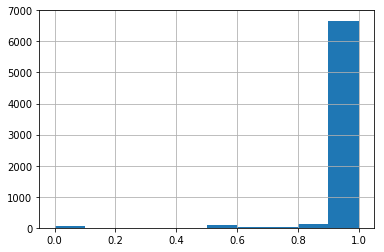

In [29]:
# différences sur les codes de ligne
routepoints['line_code_confidence'] = routepoints[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['line_code_confidence'].hist()

In [30]:
routepoints_ = routepoints[routepoints['line_code_confidence'] < 0.8]
routepoints_ = routepoints_[['gtfs_route_short_name', 'osm_code']]
grouped = routepoints_.groupby(['gtfs_route_short_name', 'osm_code'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
unique_df = routepoints_.reindex(index)
unique_df

,gtfs_route_short_name,osm_code
10114,MONTBUS,526
10111,NEY-FLA,519
3984,RE,RÉ
10113,NAVETTE,524
10108,BIEVRES,513
4740,CITA,Citalien
0,CEN,Centaure
4794,MONTMAR,Montmartrobus
4358,FA-LYCEE,FA Lycée
10103,CHARONN,501


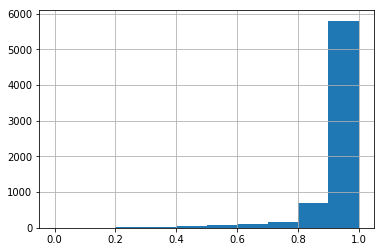

In [31]:
# différences sur les noms des arrêts
routepoints['name_confidence'] = routepoints[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['name_confidence'].hist()

In [32]:
routepoints_ = routepoints[routepoints['name_confidence'] < 0.5]
routepoints_ = routepoints_[['gtfs_stop_name', 'osm_name']]
grouped = routepoints_.groupby(['gtfs_stop_name', 'osm_name'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
unique_df = routepoints_.reindex(index)
unique_df.head()

,gtfs_stop_name,osm_name
162,Gare d'Igny,Igny RER
7461,BRANCION - MORILLONS,Morillons - Brancion
12606,GARE DE NOISIEL,Noisiel - Le Luzard RER
3447,Eragny Gare SNCF,Gare d'Eragny-Neuville
661,Poste,Cité Judiciaire


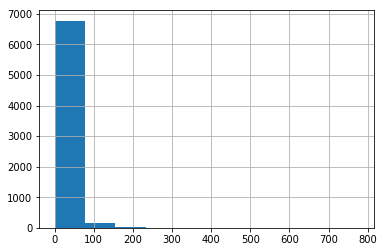

In [33]:
def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
routepoints['distance'] = routepoints.apply(compute_distance, axis=1)

routepoints['distance'].hist()

In [34]:
routepoints['distance'].mean()

17.929326027225954

In [35]:
routepoints_ = routepoints[routepoints['distance'] > 80]
len(routepoints_)

168

In [36]:
routepoints_ = routepoints_.sort_values(by='distance') #TODO : trouver un moyen sympa de visualiser ces écarts de distance
routepoints_

,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name,...,osm_osm:ref:FR:STIF,osm_osm:ref:FR:STIF:ExternalCode_Line,osm_line_id,osm_route_id,osm_lat,osm_lon,destination_confidence,line_code_confidence,name_confidence,distance
8884,StopPoint:59:3786334,100100184:184,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,PASTEUR,184,RATP,...,28582,100100184:184,Line:Relation:1259529,Route:Relation:1259521,48.797711799999995,2.3332596,0.636364,1.000000,0.947368,80.228791
8660,StopPoint:59:3786334,100100162:162,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,VAL FLEURY RER,162,RATP,...,28582,100100162:162,Line:Relation:1991746,Route:Relation:1991745,48.797711799999995,2.3332596,0.800000,1.000000,0.947368,80.228791
11120,StopPoint:59:4016293,100987782:N15,24603,BROCHANT - CARDINET,48.891322,2.318669,1,VILLEJUIF - LOUIS ARAGON-METRO,N15,Noctilien,...,24603,100987782:N15,Line:Relation:1537048,Route:Relation:1537047,48.891836,2.3179000999999997,0.851852,1.000000,1.000000,80.289990
10272,StopPoint:59:4016293,100987753:N51,24603,BROCHANT - CARDINET,48.891322,2.318669,1,GARE SAINT-LAZARE.,N51,Noctilien,...,24603,100987753:N51,Line:Relation:1553501,Route:Relation:1553500,48.891836,2.3179000999999997,0.971429,1.000000,1.000000,80.289990
6774,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,PLACE DE CLICHY,74,RATP,...,24603,100100074:74,Line:Relation:937390,Route:Relation:7925363,48.891836,2.3179000999999997,1.000000,1.000000,1.000000,80.289990
5694,StopPoint:59:4016293,100100054:54,24603,BROCHANT - CARDINET,48.891322,2.318669,1,PORTE D'AUBERVILLIERS,54,RATP,...,24603,100100054:54,Line:Relation:1257186,Route:Relation:1257179,48.891836,2.3179000999999997,1.000000,1.000000,1.000000,80.289990
6777,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,HOTEL DE VILLE,74,RATP,...,24603,100100074:74,Line:Relation:937390,Route:Relation:1253892,48.891836,2.3179000999999997,0.928571,1.000000,1.000000,80.289990
8466,StopPoint:59:4035774,100100143:143,27654,ARISTIDE BRIAND,48.926328,2.43929,1,ROSNY-SOUS-BOIS RER,143,RATP,...,27654,100100143:143,Line:Relation:4779679,Route:Relation:5912850,48.9268451,2.4385195,1.000000,1.000000,1.000000,80.590574
4421,StopPoint:29:2012,065487100:Tzen1,40570,CARRE ALLEE ROYAL,48.614672,2.532908,1,CORBEIL ESSONNES GARE RER,Tzen1,Sénart-Bus,...,40570,065487100:Tzen1,Line:Relation:1650713,Route:Relation:1650712,48.6139746,2.5326074999999997,0.960000,0.909091,0.857143,80.655647
6558,StopPoint:59:5121356,100100072:72,8443,PONT MIRABEAU,48.847043,2.273597,1,HOTEL DE VILLE,72,RATP,...,8443,100100072:72,Line:Relation:1086445,Route:Relation:1253889,48.8476843,2.2741123,0.928571,1.000000,1.000000,80.724792
